In [19]:
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import clear_output,  HTML
import uuid
import os
import imageio
import qutip
import qutip as qt
import scqubits
import numpy as np
import matplotlib.pyplot as plt
from typing import List

import math
import numpy as np
def generate_single_mapping(H_with_interaction_no_drive,
                            OVERLAP_THRESHOLD = 0) -> np.ndarray:
    """
    Returns a dictionary like {(0,0,0):0,(0,0,1):1}
    I use this function because I can adjust the OVERLAP_THRESHOLD.
    """
    evals, evecs = H_with_interaction_no_drive.eigenstates()
    overlap_matrix = scqubits.utils.spectrum_utils.convert_evecs_to_ndarray(evecs)
    product_state_names = []
    dims = H_with_interaction_no_drive.dims[0]
    system_size = len(dims)
    def generate_product_states(current_state, ele_index):
        if ele_index == system_size:
            product_state_names.append(tuple(current_state))
            return
        
        for l in range(dims[ele_index]):
            current_state[ele_index] = l
            generate_product_states(current_state.copy(), ele_index + 1)

    current_state = [0] * system_size
    generate_product_states(current_state, 0)



    total_dim = math.prod(dims)
    dressed_indices = [None] * total_dim
    for dressed_index in range(len(evals)):
        max_position = (np.abs(overlap_matrix[dressed_index, :])).argmax()
        max_overlap = np.abs(overlap_matrix[dressed_index, max_position])
        if (max_overlap**2 > OVERLAP_THRESHOLD):
            overlap_matrix[:, max_position] = 0
            dressed_indices[int(max_position)] = dressed_index
        else:
            print(f'max overlap^2 {max_overlap**2} below threshold for dressed state {dressed_index} with eval {evals[dressed_index]}')
    product_to_dressed = {}
    for product, dressed in zip(product_state_names,dressed_indices):
        product_to_dressed[product] = dressed
    return product_to_dressed

def dressed_transition_frequency_over_2pi(hilbertspace,s0: int, s1: int) -> float:
    return abs(
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )


def replace_non_float64_with_none(lst):
    for i in range(len(lst)):
        if type(lst[i]) is not np.float64:
            lst[i] = None
    return lst
    


done100/100


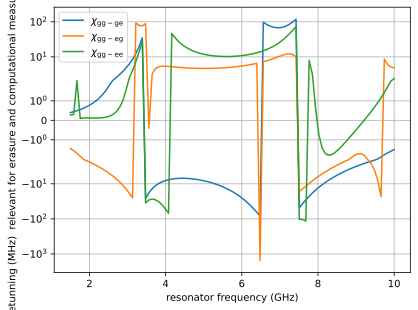

[[1.484768045594325,
  1.5704498223839414,
  1.6561122279920162,
  1.7417529224055364,
  1.8273690359729797,
  1.9129570242108267,
  1.9985124681972501,
  2.0840297963318886,
  2.1695018897564715,
  2.254919511364863,
  2.3402704600418693,
  2.4255382839456936,
  2.510700261810152,
  2.5957241212848783,
  2.6805624786980093,
  2.76514294860161,
  2.8493495070827928,
  2.9329848783871184,
  3.0156881832971876,
  3.096737111161036,
  3.1745292476841755,
  3.245230877352594,
  3.300846548863314,
  3.5088089003296057,
  3.5775958189648445,
  3.6545015780401378,
  3.735086732949717,
  3.8174969607083344,
  3.9009103762472517,
  3.984922979941504,
  4.069316689937521,
  4.153964332965124,
  4.238786897189659,
  4.323732617239161,
  4.408765986174809,
  4.493861624574219,
  4.5790006786341575,
  4.664168606032559,
  4.749353757530056,
  4.834546431604544,
  4.919738218212657,
  5.004921522401971,
  5.090089200039779,
  5.175234261629572,
  5.260349613833936,
  5.345427815997057,
  5.430460832

In [37]:
def sweep_resonator_frequency_for_detunning(EJ = 5.5,
                            EC =1.5,
                            EL = 1,
                            flux_ext = 0.5,
                            molecule_coupling = 0.3,
                            g = 0.3):

    E_vals = np.linspace(1.5, 10, 100)
    gg_vals = []
    ge_vals = []
    eg_vals = []
    ee_vals = []

    assymetry = 0.00001
    flux_1 = (2+assymetry)/2*flux_ext
    flux_2 = (2-assymetry)/2*flux_ext

    qubit_levels = 4
    osc_levels = 4

    qubit1 = scqubits.Fluxonium(EJ = EJ,
                        EC =EC,
                        EL = EL,
                        flux = flux_1,
                        cutoff = 110,
                        truncated_dim = qubit_levels)
    qubit2 = scqubits.Fluxonium(EJ = EJ,
                        EC =EC,
                        EL = EL,
                        flux = flux_2,
                        cutoff = 110,
                        truncated_dim = qubit_levels)

    num_completed = 0
    for e in E_vals:
        osc = scqubits.Oscillator(
            E_osc=e,
            l_osc = 1,
            truncated_dim=osc_levels
        )
        hilbertspace = scqubits.HilbertSpace([qubit1,qubit2, osc])
        
        hilbertspace.add_interaction(
            g_strength=molecule_coupling, op1=qubit1.phi_operator, op2=qubit2.phi_operator, add_hc=False
        )
        hilbertspace.add_interaction(
            g_strength=g, op1=qubit1.n_operator, op2=osc.creation_operator, add_hc=True
        )

        hilbertspace.add_interaction(
            g_strength=g, op1=qubit2.n_operator, op2=osc.creation_operator, add_hc=True
        )
        hilbertspace.generate_lookup()
        qlqlrl_to_dressed_level = generate_single_mapping(hilbertspace.hamiltonian())

        gg = dressed_transition_frequency_over_2pi(hilbertspace,qlqlrl_to_dressed_level[(0,0,0)],qlqlrl_to_dressed_level[(0,0,1)])
        ge = dressed_transition_frequency_over_2pi(hilbertspace,qlqlrl_to_dressed_level[(0,1,0)],qlqlrl_to_dressed_level[(0,1,1)])
        eg = dressed_transition_frequency_over_2pi(hilbertspace,qlqlrl_to_dressed_level[(1,0,0)],qlqlrl_to_dressed_level[(1,0,1)])
        ee = dressed_transition_frequency_over_2pi(hilbertspace,qlqlrl_to_dressed_level[(1,1,0)],qlqlrl_to_dressed_level[(1,1,1)])

        gg_vals.append(gg)
        ge_vals.append(ge)
        eg_vals.append(eg)
        ee_vals.append(ee)

        clear_output()
        num_completed += 1
        print(f"done{num_completed}/{len(E_vals)}")

    gg_vals = replace_non_float64_with_none(gg_vals)
    ge_vals = replace_non_float64_with_none(ge_vals)
    eg_vals = replace_non_float64_with_none(eg_vals)
    ee_vals = replace_non_float64_with_none(ee_vals)

    chi_gg_ge_MHz = []
    for a, b in zip(ge_vals, gg_vals):
        if a is None or b is None:
            chi_gg_ge_MHz.append(None)
        else:
            chi_gg_ge_MHz.append((a - b)/2*1000)
    chi_gg_eg_MHz = []
    for a, b in zip(eg_vals, gg_vals):
        if a is None or b is None:
            chi_gg_eg_MHz.append(None)
        else:
            chi_gg_eg_MHz.append((a - b)/2*1000)
    chi_gg_ee_MHz = []
    for a, b in zip(ee_vals, gg_vals):
        if a is None or b is None:
            chi_gg_ee_MHz.append(None)
        else:
            chi_gg_ee_MHz.append((a - b)/2*1000)

    plt.plot(E_vals, chi_gg_ge_MHz, label=r'$\chi_{\mathrm{gg-ge}}$')
    plt.plot(E_vals, chi_gg_eg_MHz, label=r'$\chi_{\mathrm{gg-eg}}$')
    plt.plot(E_vals, chi_gg_ee_MHz, label=r'$\chi_{\mathrm{gg-ee}}$')
    plt.yscale('symlog')
    plt.legend()
    # plt.ylim([-100,100])
    plt.gca().yaxis.grid(True)
    plt.gca().xaxis.grid(True)
    plt.xlabel("resonator frequency (GHz)")
    plt.ylabel("detunning (MHz)  relevant for erasure and computational measurement")
    plt.show()
    return [gg_vals,ge_vals,eg_vals,ee_vals]


sweep_resonator_frequency_for_detunning()

In [62]:


def try_osc_freq(freq):
    qubit_levels = 5
    osc_levels = 6
    fluxonium =  Fluxonium(EJ = 5.5,
                            EC =1.3,
                            EL = 1,
                            flux = 0.5,
                            cutoff = 110,
                            truncated_dim = qubit_levels)
    osc = Oscillator(
        E_osc=freq,
        # E_osc = 2.9,
        l_osc = 1,
        truncated_dim=osc_levels
    )
    hilbertspace = HilbertSpace([fluxonium, osc])
    g = 0.3

    hilbertspace.add_interaction(
        g_strength=g, op1=fluxonium.n_operator, op2=osc.creation_operator, add_hc=True
    )
    hilbertspace.generate_lookup()

    product_to_dressed = generate_single_mapping(hilbertspace.hamiltonian())

    a = hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator)
    a_dag = hilbertspace.op_in_dressed_eigenbasis(op=osc.creation_operator)

    a = qutip.Qobj(a[:, :])# So that everything that goes into mesolve is like a product
    a_dag =  qutip.Qobj(a[:, :])

    (evals,) = hilbertspace["evals"]
    diag_dressed_hamiltonian = (
            2 * np.pi * qutip.Qobj(np.diag(evals),
            dims=[hilbertspace.subsystem_dims] * 2)
    )
    diag_dressed_hamiltonian = qutip.Qobj(diag_dressed_hamiltonian[:, :])

    def transition_frequency(s0: int, s1: int) -> float:
        return ((
                hilbertspace.energy_by_dressed_index(s1)
                - hilbertspace.energy_by_dressed_index(s0)
            ))

    w_d = transition_frequency(product_to_dressed[(2,0)], product_to_dressed[(2,1)])

    tot_time = 100
    
    matrix_element_driven = abs((a+a_dag).data.toarray()[product_to_dressed[(2,0)]][product_to_dressed[(2,1)]])
    A_square = 1/tot_time
    A_square = A_square/matrix_element_driven
    def square_cos(t,*args):
        cos = np.cos(w_d * 2*np.pi * t)
        return  2*np.pi *A_square * cos
        
    H_with_drive = [
        diag_dressed_hamiltonian,
        [a+a.dag(), square_cos]]

    tot_time = tot_time * 2
    tlist = np.linspace(0, tot_time, tot_time*2)

    product_states = [(0, 0), (1, 0), (2,0), (3,0),  (0, 1), (1, 1), (2,1),(3,1)]
    idxs = [product_to_dressed[(s1, s2)] for (s1, s2) in product_states]
    qutip_states = [qutip.basis(hilbertspace.dimension, idx) for idx in idxs]

    results = []
    for i in range(4):
        temp = qutip.mesolve(
            H = H_with_drive,
            rho0 = qutip.basis(hilbertspace.dimension, product_to_dressed[(i,0)]),
            tlist = tlist,
            e_ops=[state * state.dag() for state in qutip_states]+[a,
                                                                a.dag()*a,
                                                                ],
            options=qutip.Options(store_states=True,nsteps=1000)
        )
        results.append(temp)
    dominant_freq = []
    for i in range(4):
        dominant_freq.append(find_dominant_frequency(results[i].expect[-2],tlist))


    dictionary = {0: 'g', 1: 'e', 2: 'f', 3: 'h'}
    fig, axes = plt.subplots(4, 4, figsize=(9, 6))

    for i in range(4):
        for idx, res in zip(idxs, results[i].expect):
            product_state = product_states[idxs.index(idx)]
            qubit_state = dictionary[product_state[0]]
            resonator_state = product_state[1]
            axes[0][i].plot(tlist, res, label=r"$|%s\rangle$" % (str(",".join([qubit_state,str(resonator_state)]))))
        
        alpha = results[i].expect[-2]*np.exp(-1j * 2 * np.pi * dominant_freq[i] * tlist)  
        real = alpha.real
        imag = alpha.imag
        axes[0][i].plot(tlist, results[i].expect[-1], label=r"photon number")
        axes[1][i].plot(tlist,imag , label=r"imag alpha")
        axes[2][i].plot(tlist, real, label=r"real alpha")
        axes[3][i].plot(-imag, real, label=r"imag alpha VS real alpha")

    axes[0][3].legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))
    axes[1][3].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
    axes[2][3].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
    axes[3][3].legend(loc='center', ncol=1, bbox_to_anchor=(1.4, 0.5))
    plt.ylabel("population")
    plt.xlabel("t (ns)")
    for row in range(4):
        max_x_range,min_x_range,max_y_range,min_y_range = 0,0,0,0
        for col in [0,1,2,3]:
            ymin, ymax = axes[row][col].get_ylim()
            xmin, xmax = axes[row][col].get_xlim()
            if ymax > max_y_range:
                max_y_range = ymax
            if ymin < min_y_range:
                min_y_range = ymin
            if xmax > max_x_range:
                max_x_range = xmax
            if xmin < min_x_range:
                min_x_range = xmin
        for col in [0,1,2,3]:
            axes[row][col].set_ylim(min_y_range, max_y_range)
            axes[row][col].set_xlim(min_x_range,max_x_range)
    # plt.yscale('log')
    # plt.show()

    def convert_dressed_state_to_LC_basis_product_state(dressed_state:qutip.Qobj):
        # This conversion is an approximation for easy partial trace later
        dressed_state = dressed_state.data.toarray()
        product_state = np.zeros((qubit_levels*osc_levels,1), dtype=np.complex128)
        for ql in range(qubit_levels):
            for ol in range(osc_levels):
                index_in_product_state = ql*osc_levels + ol
                corresponding_dressed_index = product_to_dressed[(ql,ol)]
                product_state[index_in_product_state][0] = dressed_state[corresponding_dressed_index][0]

        product_state = qutip.Qobj(product_state,dims = [[qubit_levels ,osc_levels],[1,1]])
        return product_state

    def plot_t_dep_Husimi(t,tlist,results, file_name = None):
        t = min(enumerate(tlist), key=lambda x:abs(x[1]-t))[0]
        fig, axes = plt.subplots(1, 4, figsize=(8, 3))
        cbar_ax = fig.add_axes([.91, .3, .03, .4])
        x = np.linspace(-2*np.pi, 2*np.pi, 100)
        
        a_bare = qt.destroy(osc_levels)

        for initial_state in [0,1,2,3]: 
            state = results[initial_state].states[t]
            product_state = convert_dressed_state_to_LC_basis_product_state(state)
            reduced_rho = qt.ptrace(product_state, 1)

            # theta = dominant_freq[i] * t
            # rotation_operator = (-1j * a_bare.dag() * a_bare * theta).expm()

            # reduced_rho_rotated = rotation_operator.dag() * reduced_rho * rotation_operator

            # reduced_rho_rotated = (reduced_rho_rotated + reduced_rho_rotated.dag()) / 2 # Make it hermitian
            # reduced_rho_rotated = reduced_rho_rotated / reduced_rho_rotated.tr()

            # R = qt.qfunc(state = reduced_rho_rotated,xvec=x,yvec=x)

            R = qt.qfunc(state = reduced_rho,xvec=x,yvec=x)
            im = axes[initial_state].imshow(R, extent=(-2*np.pi, 2*np.pi, -2*np.pi, 2*np.pi), 
                                            origin='lower',  cmap=cmap,  vmin=0, vmax=1/np.pi)
        fig.colorbar(im, cax=cbar_ax)
        if file_name == None:
            plt.show()
        else:
            plt.savefig(file_name)
            plt.clf()
            plt.close()


    def make_husimi_gif(tlist,results):
        folder = str(uuid.uuid4())
        os.makedirs(folder)
        num_steps = 40
        step = len(tlist) / num_steps
        chosen_t_indices = [i * step for i in range(num_steps)]
        chosen_t_indices.append(len(tlist)-1)
        file_name_list = []
        num_finished = 0
        for t_idx in chosen_t_indices:
            file_name = folder+'/'+str(t_idx) + '.png'
            plot_t_dep_Husimi(tlist[int(t_idx)],tlist,results,file_name = file_name)
            file_name_list.append(file_name)
            clear_output(wait=True)
            num_finished += 1
            print(f'finished {num_finished} out of {num_steps}')
        with imageio.get_writer(f'{folder}/Husimi.gif', mode='I') as writer:
            for file_name in file_name_list:
                image = imageio.imread(file_name)
                writer.append_data(image)
        clear_output(wait=True)
        HTML(f'<img src="{folder}/Husimi.gif">')
    make_husimi_gif(tlist,results)

    plt.show()



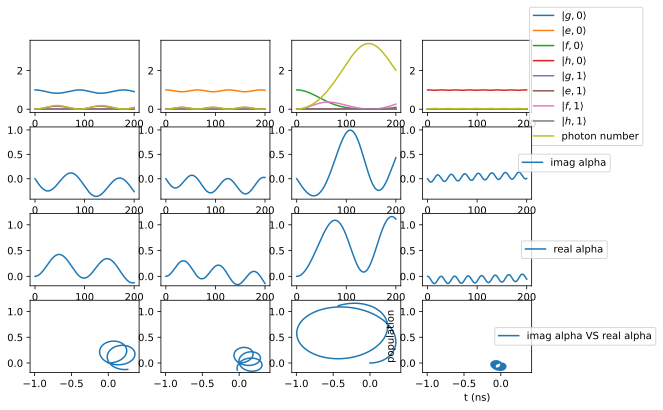

In [63]:
results = try_osc_freq(7)